# Start-to-Finish Example: Numerical Solution of the Scalar Wave Equation, in Curvilinear Coordinates

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module solves the scalar wave equation for a plane wave in *spherical coordinates* (though other coordinates, including Cartesian, may be chosen).

**Module Status:** <font color ="green"><b> Validated </b></font>

**Validation Notes:** This module has been validated to converge at the expected order to the exact solution (see [plot](#convergence) at bottom).

### NRPy+ Source Code for this module: 
* [ScalarWaveCurvilinear/ScalarWaveCurvilinear_RHSs.py](../edit/ScalarWaveCurvlinear/ScalarWaveCurvilinear_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWaveCurvilinear.ipynb) Generates the right-hand side for the Scalar Wave Equation in curvilinear coordinates
* [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generating C code for plane wave initial data for the scalar wave equation 

## Introduction:
As outlined in the [previous NRPy+ tutorial module](Tutorial-ScalarWaveCurvilinear.ipynb), we first use NRPy+ to generate initial data for the scalar wave equation, and then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate scalar wave RHS expressions.</font>
    1. Apply boundary conditions.
1. At the end of each iteration in time, output the relative error between numerical and exact solutions.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows

1. [Step 1](#writec): Using NRPy+ to generate necessary C code to solve the scalar wave equation in curvilinear, singular coordinates
    1. [Step 1.a](#id_rhss): C code generation: Initial data and scalar wave RHSs 
    1. [Step 1.b](#boundaryconditions): C code generation: Boundary condition driver
    1. [Step 1.c](#cfl): C code generation: Finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 2](#mainc): `ScalarWaveCurvilinear_Playground-SIMD.c`: The Main C Code
1. [Step 3](#convergence): Code validation: Verify that relative error in numerical solution converges to zero at the expected order
1. [Step 4](#latex_pdf_output): Output this module to $\LaTeX$-formatted PDF file

<a id='writec'></a>

# Step 1: Using NRPy+ to generate necessary C code to solve the scalar wave equation in curvilinear, singular coordinates \[Back to [top](#toc)\]
$$\label{writec}$$

<a id='outputc'></a>

## Step 1.a: C code generation: Initial data and scalar wave RHSs \[Back to [top](#toc)\]
$$\label{outputc}$$


We choose simple plane wave initial data, which is documented in the [Cartesian scalar wave module](Tutorial-ScalarWave.ipynb). Specifically, we implement monochromatic (single-wavelength) wave traveling in the $\hat{k}$ direction with speed $c$
$$u(\vec{x},t) = f(\hat{k}\cdot\vec{x} - c t),$$
where $\hat{k}$ is a unit vector.

The scalar wave RHSs in curvilinear coordinates (documented [in the previous module](Tutorial-ScalarWaveCurvilinear.ipynb)) are simply the right-hand sides of the scalar wave equation written in curvilinear coordinates
\begin{align}
\partial_t u &= v \\
\partial_t v &= c^2 \left(\hat{g}^{ij} \partial_{i} \partial_{j} u - \hat{\Gamma}^i \partial_i u\right),
\end{align}
where $\hat{g}^{ij}$ is the inverse reference 3-metric (i.e., the metric corresponding to the underlying coordinate system we choose$-$spherical coordinates in our example below), and $\hat{\Gamma}^i$ is the contracted Christoffel symbol $\hat{\Gamma}^\tau = \hat{g}^{\mu\nu} \hat{\Gamma}^\tau_{\mu\nu}$.

Below we generate 
+ the initial data by calling `InitialData_PlaneWave()` inside the NRPy+ [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py) module (documented in [this NRPy+ Jupyter notebook](Tutorial-ScalarWave.ipynb)), and 
+ the RHS expressions by calling `ScalarWaveCurvilinear_RHSs()` inside the NRPy+ [ScalarWaveCurvilinear/ScalarWaveCurvilinear_RHSs.py](../edit/ScalarWaveCurvilinear/ScalarWaveCurvilinear_RHSs.py) module (documented in [this NRPy+ Jupyter notebook](Tutorial-ScalarWaveCurvilinear.ipynb)).

In [1]:
# Step P1: Import needed NRPy+ core modules:
import NRPy_param_funcs as par
import indexedexp as ixp
import grid as gri
import reference_metric as rfm
import finite_difference as fin
import loop as lp
from outputC import *
import sys

#Step P2: Create C code output directory:
!rm -r ScalarWaveCurvilinear_Playground_Ccodes
import shutil, os
outdir = os.path.join("ScalarWaveCurvilinear_Playground_Ccodes/")
import cmdline_helper as cmd
cmd.mkdir(outdir)

# Step 1: Set the spatial dimension parameter 
#         to three this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 2: Set some core parameters, including order of MoL timestepping, FD order, 
#                                 floating point precision, and CFL factor:
# Choices are: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4        # Even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
CFL_FACTOR= 1.0
# Step 3: Generate Runge-Kutta-based (RK-based) timestepping code. 
#         Each RK substep involves two function calls:
#      3.A: Evaluate RHSs (RHS_string)
#      3.B: Apply boundary conditions (post_RHS_string)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(outdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method, 
    RHS_string      = "rhs_eval(&rfmstruct, &params, RK_INPUT_GFS, RK_OUTPUT_GFS);",
    post_RHS_string = "apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_OUTPUT_GFS);",
    outdir = os.path.join(outdir,"MoLtimestepping/"))

# Step 4: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","SinhSpherical")

# Step 5: Import the ScalarWave.InitialData module. 
#         This command only declares ScalarWave initial data 
#         parameters and the InitialData_PlaneWave() function.
import ScalarWave.InitialData_PlaneWave as swid

# Step 6: Import ScalarWave_RHSs module. 
#         This command only declares ScalarWave RHS parameters
#         and the ScalarWave_RHSs function (called later)
import ScalarWaveCurvilinear.ScalarWaveCurvilinear_RHSs as swrhs

# Step 7: Set the finite differencing order to 6.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",FD_order)

# Step 8: Generate SymPy symbolic expressions for
#         monochromatic (single frequency/wavelength)
#         plane wave initial data.
swid.InitialData_PlaneWave()

# Step 9: Generate SymPy symbolic expressions for
#         uu_rhs and vv_rhs; the ScalarWave RHSs.
#         This function also declares the uu and vv
#         gridfunctions, which need to be declared
#         to output even the initial data to C file.
cmd.mkdir(os.path.join(outdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(outdir,"rfm_files/"))
swrhs.ScalarWaveCurvilinear_RHSs()
# Step 9.a: Now that we are finished with all the rfm hatted
#           quantities, let's restore them to their closed-
#           form expressions.
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()

# Step 10: Copy SIMD/SIMD_intrinsics.h to $outdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(outdir,"SIMD"))
shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(outdir,"SIMD/"))

# Step 11: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(outdir))

# Step 12: Generate C code for the initial data.
IDstring = fin.FD_outputC("returnstring",[lhrh(lhs="*uu_exact",rhs=swid.uu_ID),
                                          lhrh(lhs="*vv_exact",rhs=swid.vv_ID)])
with open(outdir+"ScalarWaveCartesian_ExactSolution_single_point.h", "w") as file:
    file.write(IDstring.replace("IDX4","IDX4S"))

with open(outdir+"ScalarWaveCartesian_ExactSolution.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["0","0","0"],
                       ["Nxx_plus_2NGHOSTS2","Nxx_plus_2NGHOSTS1","Nxx_plus_2NGHOSTS0"],["1","1","1"],
                       ["#pragma omp parallel for","",""],"",
"""
REAL xCart[3]; xxCart(params,xx, i0,i1,i2, xCart);
REAL xx0 = xCart[0]; REAL xx1 = xCart[1]; REAL xx2 = xCart[2];
exact_solution_single_point(xx0,xx1,xx2,params,&in_gfs[IDX4S(UUGF,i0,i1,i2)],&in_gfs[IDX4S(VVGF,i0,i1,i2)]);
"""))

# Step 13: Generate C code for scalarwave RHSs,
#          output to a file named "SENR/ScalarWave_RHSs.h".
RHSstring = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=swrhs.uu_rhs),
                                           lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=swrhs.vv_rhs)],
                          "SIMD_enable=True")
with open(outdir+"ScalarWaveCurvilinear_RHSs.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx2","NGHOSTS+Nxx1","NGHOSTS+Nxx0"],
                       ["1","1","SIMD_width"],
                        ["#pragma omp parallel for",
                                      "#include \"rfm_files/rfm_struct__SIMD_outer_read2.h\"",
                                      "#include \"rfm_files/rfm_struct__SIMD_outer_read1.h\""],"",
                                     "#include \"rfm_files/rfm_struct__SIMD_inner_read0.h\"\n"+RHSstring.replace("IDX4","IDX4S")))

<a id='boundaryconditions'></a>

## Step 1.b: Output needed C code for boundary condition driver \[Back to [top](#toc)\]
$$\label{boundaryconditions}$$

In [2]:
import CurviBoundaryConditions_opt.CurviBoundaryConditions_opt as cbcs
cmd.mkdir(os.path.join(outdir,"boundary_conditions/"))
for file in ["apply_bcs_curvilinear.h","BCs_data_structs.h","bcstruct_freemem.h","CurviBC_include_Cfunctions.h",
          "driver_bcstruct.h","set_bcstruct.h","set_up__bc_gz_map_and_parity_condns.h"]:
    shutil.copy(os.path.join("CurviBoundaryConditions_opt","boundary_conditions", file), 
                os.path.join(outdir,"boundary_conditions/"))
cbcs.Set_up_CurviBoundaryConditions(os.path.join(outdir,"boundary_conditions/"))

Wrote to file "ScalarWaveCurvilinear_Playground_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved gridfunction "uu" has parity type 0.
Evolved gridfunction "vv" has parity type 0.
Wrote to file "ScalarWaveCurvilinear_Playground_Ccodes/boundary_conditions/xxCart.h"
Wrote to file "ScalarWaveCurvilinear_Playground_Ccodes/boundary_conditions/xxminmax.h"
Wrote to file "ScalarWaveCurvilinear_Playground_Ccodes/boundary_conditions/Cart_to_xx.h"


<a id='cfl'></a>

## Step 1.c: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [3]:
# Generic coordinate NRPy+ file output, Part 4: output the proper distance between gridpoints in given coordinate system
dxx     = ixp.declarerank1("dxx",DIM=3)
ds_dirn = rfm.ds_dirn(dxx)
outputC([ds_dirn[0],ds_dirn[1],ds_dirn[2]],["ds_dirn0","ds_dirn1","ds_dirn2"],outdir+"ds_dirn.h")

Wrote to file "ScalarWaveCurvilinear_Playground_Ccodes/ds_dirn.h"


<a id='mainc'></a>

# Step 2: `ScalarWaveCurvilinear_Playground-SIMD.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

Just as in [the start-to-finish, solving the scalar wave equation in Cartesian coordinates module](Tutorial-Start_to_Finish-ScalarWave.ipynb), we will implement the scalar wave equation via the Method of Lines. As discussed above, the critical differences between this code and the Cartesian version are as follows:
1. The CFL-constrained timestep depends on the proper distance between neighboring gridpoints
1. The boundary conditions must account for the fact that ghost zone points lying in the domain exterior can map either to the interior of the domain, or lie on the outer boundary. In the former case, we simply copy the data from the interior. In the latter case, we apply the usual outer boundary conditions.
1. The numerical grids must be staggered to avoid direct evaluation of the equations on coordinate singularities.

In [4]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER),
#          and set the CFL_FACTOR (which can be overwritten at the command line)

with open(outdir+"ScalarWaveCurvilinear_Playground_REAL__NGHOSTS__CFL_FACTOR.h", "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(int(FD_order/2))+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"""
// Part P0.c: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
REAL CFL_FACTOR = """+str(CFL_FACTOR)+";\n")

In [5]:
%%writefile $outdir/ScalarWaveCurvilinear_Playground-SIMD.c

// Step P0: Define REAL and NGHOSTS; and declare CFL_FACTOR. This header is generated in NRPy+.
#include "ScalarWaveCurvilinear_Playground_REAL__NGHOSTS__CFL_FACTOR.h"

#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

// All SIMD intrinsics used in SIMD-enabled C code loops are defined here:
#include "SIMD/SIMD_intrinsics.h"

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Part P3: Set UUGF and VVGF macros, as well as xxCart()
#include "boundary_conditions/gridfunction_defines.h"

inline void xxCart(const paramstruct *restrict params, REAL *restrict xx[3],
                   const int i0,const int i1,const int i2, REAL xCart[3]) {
#include "set_Cparameters.h"
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "boundary_conditions/xxCart.h"
}

// Step P4: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

// Step P5: Find the CFL-constrained timestep
REAL find_timestep(const paramstruct *restrict params, REAL *restrict xx[3]) {
#include "set_Cparameters.h"
    REAL dsmin = 1e38; // Start with a crazy high value... close to the largest number in single precision.
    LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS, 
                NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS, 
                NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
        const REAL xx0 = xx[0][i0], xx1 = xx[1][i1], xx2 = xx[2][i2];
        REAL ds_dirn0, ds_dirn1, ds_dirn2;
        #include "ds_dirn.h"
        #ifndef MIN
        #define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
        #endif
        // Set dsmin = MIN(dsmin, ds_dirn0, ds_dirn1, ds_dirn2);
        dsmin = MIN(dsmin,MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2)));
    }
    return dsmin*CFL_FACTOR/wavespeed;
}

// Part P6: Declare the functions for the exact solution.
inline void exact_solution_single_point(const REAL xx0,const REAL xx1,const REAL xx2,
                                        const paramstruct *restrict params,
                                        REAL *uu_exact, REAL *vv_exact) {
#include "set_Cparameters.h"
#include "ScalarWaveCartesian_ExactSolution_single_point.h"
}
void exact_solution_all_points(const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs) {
#include "set_Cparameters.h"
#include "ScalarWaveCartesian_ExactSolution.h"
}

// Part P7: Declare the function to evaluate the scalar wave RHSs
void rhs_eval(rfm_struct *restrict rfmstruct,
              const paramstruct *restrict params, 
              const REAL *restrict in_gfs,REAL *restrict rhs_gfs) {
#include "set_Cparameters-SIMD.h"
#include "ScalarWaveCurvilinear_RHSs.h"
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Output relative error between numerical and exact solution.
// Step 3: Evolve scalar wave initial data forward in time using Method of Lines with chosen RK-like algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"
    
    // Step 0a: Read command-line input, error out if nonconformant
    if(argc != 4 || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < NGHOSTS) {
        printf("Error: Expected one command-line argument: ./ScalarWaveCurvilinear_Playground Nx0 Nx1 Nx2,\n");
        printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }

    // Set free-parameter values.
    params.time = 0.0;
    params.wavespeed = 1.0;
    params.kk0 = 1.0;
    params.kk1 = 1.0;
    params.kk2 = 1.0;
    
    // Override parameter defaults with values based on command line arguments and NGHOSTS.
    params.Nxx0 = Nxx[0];
    params.Nxx1 = Nxx[1];
    params.Nxx2 = Nxx[2];
    params.Nxx_plus_2NGHOSTS0 = Nxx[0] + 2*NGHOSTS;
    params.Nxx_plus_2NGHOSTS1 = Nxx[1] + 2*NGHOSTS;
    params.Nxx_plus_2NGHOSTS2 = Nxx[2] + 2*NGHOSTS;
    params.AMPL = 10.0;
    params.SINHW=  0.4;
    
    // Step 0d: Set up space and time coordinates
    // Step 0d.i: Set \Delta x^i=dxx{0,1,2} and invdxx{0,1,2} parameters.
    {
#include "set_Cparameters-nopointer.h"

#include "boundary_conditions/xxminmax.h"
    params.dxx0 = (xxmax[0] - xxmin[0]) / ((REAL)Nxx[0]);
    params.dxx1 = (xxmax[1] - xxmin[1]) / ((REAL)Nxx[1]);
    params.dxx2 = (xxmax[2] - xxmin[2]) / ((REAL)Nxx[2]);
    params.invdx0 = 1.0/params.dxx0;
    params.invdx1 = 1.0/params.dxx1;
    params.invdx2 = 1.0/params.dxx2;
    }
    // Now that params.dxx{0,1,2} and params.invdxx{0,1,2} have been set,
    // Step 0d.ii: Declare dxx{0,1,2} and invdxx{0,1,2}, as well as xxmin[3] and xxmax[3]:
#include "set_Cparameters-nopointer.h"
#include "boundary_conditions/xxminmax.h"

    // Step 0d.iii: Set up uniform coordinate grids
    REAL *xx[3];
    xx[0] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS0);
    for(int j=0;j<Nxx_plus_2NGHOSTS0;j++) xx[0][j] = xxmin[0] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx0; // Cell-centered grid.
    xx[1] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS1);
    for(int j=0;j<Nxx_plus_2NGHOSTS1;j++) xx[1][j] = xxmin[1] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx1; // Cell-centered grid.
    xx[2] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS2);
    for(int j=0;j<Nxx_plus_2NGHOSTS2;j++) xx[2][j] = xxmin[2] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx2; // Cell-centered grid.

    // Step 0d.iv: Set Nxx_plus_2NGHOSTS_tot
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
    
    // Step 0e: Find ghostzone mappings; set up bcstruct:
#include "boundary_conditions/driver_bcstruct.h"

    // Step 0f: Set length & timescales for problem:
    // Step 0f.i: Set lengthscale for problem:
    const REAL RMAX = params.AMPL;

    // Step 0f.ii: Time coordinate parameters
    const REAL t_final =  0.7*RMAX; /* Final time is set so that at t=t_final, 
                                     * data at the origin have not been corrupted 
                                     * by the approximate outer boundary condition */
    
    // Step 0g: Set timestep based on smallest proper distance between gridpoints and CFL factor 
    REAL dt = find_timestep(&params, xx);
    //printf("# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of points in time. 
                                             // Add 0.5 to account for C rounding down 
                                             // typecasts to integers.
    int output_every_N = (int)((REAL)N_final/800.0);
    if(output_every_N == 0) output_every_N = 1;

    // Step 0h: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
    //              This is a limitation of the RK method. You are always welcome to declare & allocate 
    //              additional gridfunctions by hand.
    if(NUM_AUX_GFS > NUM_EVOL_GFS) {
        printf("Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
        printf("       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
        exit(1);
    }
    
    // Step 0i: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    
    // Step 0j: Set up precomputed referenc metric arrays
    // Step 0j.i: Allocate space for precomputed reference metric arrays.
#include "rfm_files/rfm_struct__malloc.h"

    // Step 0k.ii: Define precomputed reference metric arrays.
    {
const REAL AMPL = params.AMPL;
const REAL SINHW = params.SINHW;
        #include "rfm_files/rfm_struct__define.h"
    }

    // Step 1: Set up initial data to be exact solution at time=0:
    params.time = 0.0; exact_solution_all_points(&params, xx, y_n_gfs);

    for(int n=0;n<=N_final;n++) 
       { // Main loop to progress forward in time. 

        // Step 1a: Set current time to correct value & compute exact solution
        params.time = ((REAL)n)*dt;

        // Step 2: Code validation: Compute log of L2 norm of difference
        //         between numerical and exact solutions:
        //   log_L2_Norm = log10( sqrt[Integral( [numerical - exact]^2 * dV)] ),
        //         where integral is within 30% of the grid outer boundary (RMAX)
        if(n%output_every_N == 0) {
            REAL integral = 0.0;
            REAL numpts   = 0.0;
#pragma omp parallel for reduction(+:integral,numpts)
            LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS, 
                        NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS, 
                        NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
                REAL xCart[3]; xxCart(&params,xx,i0,i1,i2, xCart);
                if(sqrt(xCart[0]*xCart[0] + xCart[1]*xCart[1] + xCart[2]*xCart[2]) < RMAX*0.3) {
                    REAL uu_exact,vv_exact; exact_solution_single_point(xCart[0],xCart[1],xCart[2],&params, 
                                                                        &uu_exact,&vv_exact);
                    double num   = (double)y_n_gfs[IDX4S(0,i0,i1,i2)];
                    double exact = (double)uu_exact;
                    integral += (num - exact)*(num - exact);
                    numpts   += 1.0;
                }
            }
            // Compute and output the log of the L2 norm.
            REAL log_L2_Norm = log10(sqrt(integral/numpts));
            printf("%e %e\n",(double)params.time,log_L2_Norm);
        }
        
        // Step 3: Step forward one timestep (t -> t+dt) in time using 
        //           chosen RK-like MoL timestepping algorithm
#include "MoLtimestepping/RK_MoL.h"

    } // End main loop to progress forward in time.

    // Step 4: Free all allocated memory
#include "rfm_files/rfm_struct__freemem.h"
#include "boundary_conditions/bcstruct_freemem.h"
#include "MoLtimestepping/RK_Free_Memory.h"
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Writing ScalarWaveCurvilinear_Playground_Ccodes//ScalarWaveCurvilinear_Playground-SIMD.c


In [6]:
import cmdline_helper as cmd

cmd.C_compile(outdir+"ScalarWaveCurvilinear_Playground-SIMD.c", "ScalarWaveCurvilinear_Playground-SIMD")
# !clang -Ofast -fopenmp -mavx2 -mfma ScalarWaveCurvilinear/ScalarWaveCurvilinear_Playground-SIMD.c -o ScalarWaveCurvilinear_Playground-SIMD -lm

# !icc -align -qopenmp -xHost -O2 -qopt-report=5 -qopt-report-phase ipo -qopt-report-phase vec -vec-threshold1 -qopt-prefetch=4 ScalarWaveCurvilinear/ScalarWaveCurvilinear_Playground-SIMD.c -o ScalarWaveCurvilinear_Playground-SIMD
# !gcc-7 -Ofast -fopenmp -march=native ScalarWaveCurvilinear/ScalarWaveCurvilinear_Playground-SIMD.c -o ScalarWaveCurvilinear_Playground-SIMD -lm

cmd.delete_existing_files("out-*resolution.txt")

if par.parval_from_str("reference_metric::CoordSystem") == "Cartesian":
    cmd.Execute("ScalarWaveCurvilinear_Playground-SIMD", "16 16 16", "out-lowresolution.txt")
    cmd.Execute("ScalarWaveCurvilinear_Playground-SIMD", "24 24 24", "out-medresolution.txt")
else:
    cmd.Execute("ScalarWaveCurvilinear_Playground-SIMD", "16  8 16", "out-lowresolution.txt")
    # 4.28s with icc and FD order = 10.
    cmd.Execute("ScalarWaveCurvilinear_Playground-SIMD", "24 12 24", "out-medresolution.txt")
    # For benchmarking purposes, FD order = 4. desktop: 17.33s
    # laptop: 51.82s on icc. 45.02s on GCC 9, 45.03s on GCC 7, 51.67s on clang
    cmd.Execute("ScalarWaveCurvilinear_Playground-SIMD", "48 24 48", "out-hghresolution.txt")

Compiling executable...
Executing `gcc -Ofast -fopenmp -march=native ScalarWaveCurvilinear_Playground_Ccodes/ScalarWaveCurvilinear_Playground-SIMD.c -o ScalarWaveCurvilinear_Playground-SIMD -lm`...
Finished executing in 1.42773389816 seconds.
Finished compilation.
Executing `taskset -c 0,1,2,3,4,5 ./ScalarWaveCurvilinear_Playground-SIMD 16  8 16`...
Finished executing in 0.22262597084 seconds.
Executing `taskset -c 0,1,2,3,4,5 ./ScalarWaveCurvilinear_Playground-SIMD 24 12 24`...
Finished executing in 0.619184970856 seconds.
Executing `taskset -c 0,1,2,3,4,5 ./ScalarWaveCurvilinear_Playground-SIMD 48 24 48`...
Finished executing in 16.5011808872 seconds.


<a id='convergence'></a>

# Step 3: Code Validation: Verify that relative error in numerical solution converges to zero at the expected order \[Back to [top](#toc)\]
$$\label{convergence}$$
The numerical solution $u_{\rm num}(x0,x1,x2,t)$ should converge to the exact solution $u_{\rm exact}(x0,x1,x2,t)$ at fourth order, which means that
$$
u_{\rm num}(x0,x1,x2,t) = u_{\rm exact}(x0,x1,x2,t) + \mathcal{O}\left((\Delta x0)^4\right)+ \mathcal{O}\left((\Delta x1)^4\right)+ \mathcal{O}\left((\Delta x2)^4\right)+ \mathcal{O}\left((\Delta t)^4\right).
$$

Thus the relative error $E_{\rm rel}$ should satisfy:
$$
\left|\frac{u_{\rm num}(x0,x1,x2,t) - u_{\rm exact}(x0,x1,x2,t)}{u_{\rm exact}(x0,x1,x2,t)}\right| + \mathcal{O}\left((\Delta x0)^4\right)+ \mathcal{O}\left((\Delta x1)^4\right)+ \mathcal{O}\left((\Delta x2)^4\right)+ \mathcal{O}\left((\Delta t)^4\right).
$$

We confirm this convergence behavior by first solving the scalar wave equation at two resolutions: $16\times 8\times 16$ (or $16^3$ if `reference_metric::CoordSystem` is set to `Cartesian`), and $24\times 12\times 24$ (or $24^3$ if `reference_metric::CoordSystem` is set to `Cartesian`) and evaluating the maximum logarithmic relative error $\log_{10} E_{\rm rel,max}$ between numerical and exact solutions within a region $R < 0.1 {\rm RMAX}$ at all iterations. 

Since we increase the resolution uniformly over all four coordinates $(x0,x1,x2,t)$, $E_{\rm rel}$ should drop uniformly as $(\Delta x0)^4$:
$$
E_{\rm rel} \propto (\Delta x0)^4.
$$

So at the two resolutions, we should find that
$$
\frac{E_{\rm rel}(16\times 8\times 16)}{E_{\rm rel}(24\times 12\times 24)} = \frac{E_{\rm rel}(16^3)}{E_{\rm rel}(24^3)} \approx \left(\frac{(\Delta x0)_{16}}{(\Delta x0)_{24}}\right)^{4} = \left(\frac{24}{16}\right)^4 \approx 5.
$$

Since we're measuring logarithmic relative error, this should be
$$
\log_{10}\left(\frac{E_{\rm rel}(16\times 8\times 16)}{E_{\rm rel}(24\times 12\times 24)}\right) = \log_{10}\left(\frac{E_{\rm rel}(16^3)}{E_{\rm rel}(24^3)}\right) \approx \log_{10}(5).
$$

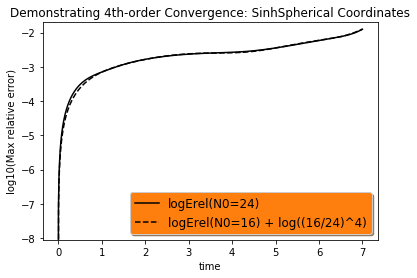

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        data1 = []
        for i in range(len(data[0])):
            data0.append(float(data[0][i]))
            data1.append(float(data[1][i]))
        return data0,data1

first_col16,second_col16 = file_reader('out-lowresolution.txt')
first_col24,second_col24 = file_reader('out-medresolution.txt')

second_col16_rescaled4o = []
second_col16_rescaled5o = []
for i in range(len(second_col16)):
    # data16 = data24*(16/24)**4
    # -> log10(data24) = log10(data24) + 4*log10(16/24)
    second_col16_rescaled4o.append(second_col16[i] + 4*mp.log10(16./24.))
    second_col16_rescaled5o.append(second_col16[i] + 5*mp.log10(16./24.))

# https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py        
fig, ax = plt.subplots()

plt.title("Demonstrating 4th-order Convergence: "+par.parval_from_str("reference_metric::CoordSystem")+" Coordinates")
plt.xlabel("time")
plt.ylabel("log10(Max relative error)")

ax.plot(first_col24, second_col24, 'k-', label='logErel(N0=24)')
ax.plot(first_col16, second_col16_rescaled4o, 'k--', label='logErel(N0=16) + log((16/24)^4)')
ax.set_ylim([-8.05,-1.7]) # Manually set the y-axis range case, since the log10
                          # relative error at t=0 could be -inf or about -16, 
                          # resulting in very different-looking plots 
                          # despite the data being the same to roundoff.
if par.parval_from_str("reference_metric::CoordSystem") == "Cylindrical":
    ax.plot(first_col16, second_col16_rescaled5o, 'k.',  label='(Assuming 5th-order convergence)')
legend = ax.legend(loc='lower right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 4: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-ScalarWaveCurvilinear-SIMD.pdf](Tutorial-Start_to_Finish-ScalarWaveCurvilinear-SIMD.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [8]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-Start_to_Finish-ScalarWaveCurvilinear-opt.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWaveCurvilinear-opt.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWaveCurvilinear-opt.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWaveCurvilinear-opt.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-Start_to_Finish-ScalarWaveCurvilinear-opt.ipynb to latex
[NbConvertApp] Writing 79209 bytes to Tutorial-Start_to_Finish-ScalarWaveCurvilinear-opt.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
